## Loading fasta files of two pathogen DNA sequence records

In [ ]:
%%script true
from Bio import SeqIO

filename_acinetobacter='acinetobacter.fna'
filename_pseudomonas='pseudomonas.fna'
count = 0
for record in SeqIO.parse(filename_acinetobacter, "fasta"):
    count = count + 1

print("There were " + str(count) + " records in file " + filename_acinetobacter)

count = 0
for record in SeqIO.parse(filename_pseudomonas, "fasta"):
    count = count + 1

print("There were " + str(count) + " records in file " + filename_pseudomonas)

In [ ]:
%%script true
print("Choosing first record from each file and writing to disk")
record_acinetobacter = next(SeqIO.parse(filename_acinetobacter, "fasta"))
SeqIO.write(record_acinetobacter, "acinetobacter_record.fasta", "fasta")
record_pseudomonas = next(SeqIO.parse(filename_pseudomonas, "fasta"))
SeqIO.write(record_pseudomonas, "pseudomonas_record.fasta", "fasta")
acinetobacter_seq = next(SeqIO.parse(filename_acinetobacter, "fasta")).seq
pseudomonas_seq = next(SeqIO.parse(filename_pseudomonas, "fasta")).seq

## Ran Mummer on these sequences to get matching segments

Download mummer from  [gitHub](https://github.com/mummer4/mummer). MUMmer is a versatile alignment tool for DNA and protein sequences.

```bash
./mummer -maxmatch -s ../acinetobacter_record.fasta ../pseudomonas_record.fasta > ../acinetobacter_pseudomonas_matches.txt
```

Now, load mummer output and only select unique sequences.

In [ ]:
%%script true
def load_filtered_file(filepath):
    valid_chars = set("agtc")
    filtered_lines = []
    
    with open(filepath, 'r') as file:
        for line in file:
            line_clean = line.strip().lower()
            # keep lines that aren't empty and consist only of a, g, t, c
            if line_clean and all(char in valid_chars for char in line_clean):
                filtered_lines.append(line_clean)
    return "\n".join(filtered_lines)

# Specify the file path accordingly
filepath = "acinetobacter_pseudomonas_matches.txt"  
matching_segments = load_filtered_file(filepath)
matching_segments = matching_segments.swapcase()
matches = matching_segments.splitlines()
unique_matches = set(matches)
print("Unique matches: " + str(len(unique_matches)))

Dump the unique outputs to fasta and create pdbs using python bindings to pymol
Tools used are: 
1. [BioPython](https://biopython.org/)
2. [Pymol fnab](https://pymolwiki.org/index.php/Fnab)



In [ ]:
%%script true
fasta_str = "".join(f">\n{match}\n" for match in unique_matches)
with open("unique_matches.fasta", "w") as f:
    f.write(fasta_str)

In [ ]:
%%script true
from Bio import SeqIO
import numpy as np
import pymol
import os
from multiprocessing import Pool
pdb_dir = "dna_sequence_pdb_files/"
os.makedirs(pdb_dir, exist_ok=True)
fasta_file = "unique_matches.fasta"
nprocs = 12
with open(fasta_file, 'r') as handle:
    records = list(SeqIO.parse(handle, 'fasta'))


    def process_record(args):
        count, record = args
        print(f"Writing sequence {count} to disk")
        dna_sequence = record.seq
        pymol.cmd.do(f'fnab {dna_sequence}, name={dna_sequence}, mode=DNA, form=B, dbl_helix=1')
        pymol.cmd.save(f"{pdb_dir}/dna_sequence_{count}.pdb", f"{dna_sequence}")
        return count

    with Pool(processes=nprocs) as pool:
        counts = pool.map(process_record, enumerate(records))
    

    print(f"Total {count+1} Sequences")

In [ ]:
%%script true
import os
import subprocess
import numpy as np
from multiprocessing import Pool

dna_sequences_dir="dna_sequence_pdb_files"

peptide_models_dir="peptide_models"
peptide_model_file = "fold_2024_12_28_00_29_model_3.pdb"
peptide_pdb = os.path.join(peptide_models_dir, peptide_model_file)

home_dir = os.environ.get("HOME", "")
path_to_hdock = os.path.join(home_dir,".local", "HDOCKlite-v1.1")
hdock_bin = os.path.join(path_to_hdock, "hdock")

filenames = [os.path.splitext(f)[0] for f in os.listdir(dna_sequences_dir) if os.path.isfile(os.path.join(dna_sequences_dir, f))]
nsequences = len(filenames)
print(f"Total {nsequences} DNA sequences")

def hdock_score_best(dna_pdb, peptide_pdb):
    fname = os.path.splitext(os.path.basename(dna_pdb))[0] + "_" + os.path.splitext(os.path.basename(peptide_pdb))[0]
    output_file = f"{fname}.out"
    command = f"{hdock_bin} {peptide_pdb} {dna_pdb} -out {output_file}"
    subprocess.run(command, shell=True, stdout=subprocess.DEVNULL, check=True)
    #subprocess.run(command, shell=True, check=True)
    with open(f"{fname}.out", "r") as f:
        lines = f.readlines()
    score = float(lines[5].split()[6])
    return score

def compute_confidence_score(docking_score):
        """
        Calculate the confidence score from the docking score.
        
        The confidence score is computed using the formula:
        Confidence_score = 1.0 / (1.0 + np.exp(0.02 * (docking_score + 150)))
        
        Information obtained from http://hdock.phys.hust.edu.cn/help.php
        """
        return 1.0 / (1.0 + np.exp(0.02 * (docking_score + 150)))

def process_score(args):
    i, dna_pdb = args
    docking_score = hdock_score_best(f"{dna_sequences_dir}/{dna_pdb}.pdb", peptide_pdb)
    confidence_score = compute_confidence_score(docking_score)
    return dna_pdb, docking_score, confidence_score

nprocs = int(os.environ.get('PBS_NCPUS', '12'))
with Pool(processes=nprocs) as pool:
    results = pool.map(process_score, list(enumerate(filenames)))

print(results)

In [ ]:
%%script true
import pandas as pd

# Create the dataframe using the 'results' variable, and add the peptide file name
df = pd.DataFrame(results, columns=["DNA Sequence", "Docking Score", "Confidence Score"])
df["Peptide Model"] = peptide_pdb

# Reorder columns and sort by increasing docking score
df = df[["DNA Sequence", "Peptide Model", "Docking Score", "Confidence Score"]].sort_values(by="Docking Score", ascending=True)
print(df)
df.to_json("best_docked_scores.json", orient='records', indent=4)

## Moledular Dynamics Simulation

Now starts the molecular dynamics simulation of selected complexes from the docking above. 

first, the selected pdb needs some pre-processing. Process PDB to fix duplicate chain ids, remove P/OP1/OP2 from terminal nucleic acids, & change atom name 'C5M' to 'C7' to make compatible with AMBER-ff.

In [ ]:
%%script true
import warnings
warnings.filterwarnings("ignore")
import argparse
from Bio.PDB import PDBParser, PDBIO
import warnings
from Bio.PDB import Structure, Model, Chain, Residue, Atom
# Define atoms to remove
atoms_to_remove = {"P", "O1P", "O2P"}
dna_residues = {"DA", "DT", "DC", "DG"}  # DNA residue names
amino_acids = [
    "ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU",
    "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR"
]

def process_pdb(input_pdb, output_pdb):
    # Parse the PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("Structure", input_pdb)
    new_structure = Structure.Structure("NewStructure")
    new_model = Model.Model(0)
    new_structure.add(new_model)
    for model in structure:
        for chain in model:
            for residue in chain:
                new_chain_id = "P" if residue.get_resname() in amino_acids else ("A" if residue.id[1] > 0 else "B")
                if new_chain_id not in new_model.child_dict:
                    new_chain = Chain.Chain(new_chain_id)
                    new_model.add(new_chain)
                else:
                    new_chain = new_model[new_chain_id]

                new_residue = Residue.Residue(residue.id, residue.resname, residue.segid)
                new_chain.add(new_residue)

                for atom in residue:
                    new_atom = Atom.Atom(atom.name, atom.coord, atom.bfactor, atom.occupancy, atom.altloc, atom.fullname, atom.serial_number, atom.element)
                    # Rename C5M atom to C7
                    if new_atom.name == "C5M":
                        new_atom.name = "C7"
                        new_atom.fullname = " C7 "
                    new_residue.add(new_atom)

    # Remove specified atoms from the first DNA residue
    first_dna_residue = None
    for chain in new_model:
        for residue in chain:
            if residue.get_resname() in dna_residues:
                first_dna_residue = residue
                break
        if first_dna_residue:
            break

    if first_dna_residue:
        for atom_name in atoms_to_remove:
            if atom_name in first_dna_residue:
                first_dna_residue.detach_child(atom_name)
    
    # Remove specified atoms from the last DNA residue of all DNA chains
    for chain in new_model:
        last_dna_residue = None
        max_abs_residue_id = -1
        for residue in chain:
            if residue.get_resname() in dna_residues:
                abs_residue_id = abs(residue.id[1])
                if abs_residue_id > max_abs_residue_id:
                    max_abs_residue_id = abs_residue_id
                    last_dna_residue = residue

        if last_dna_residue:
            for atom_name in atoms_to_remove:
                if atom_name in last_dna_residue:
                    last_dna_residue.detach_child(atom_name)
    
    # Save the modified structure
    io = PDBIO()
    io.set_structure(new_structure)
    io.save(output_pdb)
    
infile = "molecular_dynamics/dna_sequence_101_fold_2024_12_28_00_29_model_0.pdb"
outfile = "molecular_dynamics/dna_sequence_101_fold_2024_12_28_00_29_model_0_processed.pdb"
# Call the processing function with the provided file names
process_pdb(infile, outfile)

simulation_psb = outfile

Nine successive steps are used:

1. Load the protein in its best -docked state. 
   
2. In-complex creation of System Topology using ``GmxSys.add_top()``, followed by boxing and solvation/neutralization.
   
3. Boxing of complex.
  
4. Solvate complex and add ions.

5. Minimisation of the structure using ``GmxSys.em_2_steps()``.

6. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.

7. Production run using ``GmxSys.production()``.
   
8.  Post-processing using `GmxSys.convert_trj().`


In [1]:
import sys
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## To use `gromacs_py` in a project

In [2]:
from gromacs_py import gmx

## Simulation setup

- Define a few variables for you simulation, like:
  
    1. simulation output folders
    2. ionic concentration
    3. number of minimisation steps
    4. equilibration and production time

### Regarding equilibriation time:
The following variables define the sim times (relative units) for each stage of the three-stage equilibriation process. Check notes below for details:

1. `HA_time`
2. `CA_time`
3. `CA_LOW_time` 


In [3]:
DATA_OUT = 'molecular_dynamics/dna_sequence_101_peptide_model_0'
# System Setup
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 10000
emtol = 10.0  	# Stop minimization when the maximum force < 10 J/mol
emstep  = 0.01      # Energy step size


# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 4.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
os.makedirs(DATA_OUT, exist_ok = True)
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 50.0

prod_step = 1000 * prod_time / dt

## Create the `GmxSys` object

Load protein information only from docked PDB file on disk

In [4]:
%%script true

pdb_file = "molecular_dynamics/dna_sequence_101_fold_2024_12_28_00_29_model_0_processed.pdb"
sys_name = 'dna_sequence_101_peptide_model_0'
complex_sys = gmx.GmxSys(name=sys_name, coor_file=pdb_file)

## Create topology and stuff

1. Topology creation involves manually running `gmx pdb2gmx` using `add_top()` function. Missing atoms are ignored, as are hydrogens.


In [5]:
%%script true
options = {'ignh': None,'missing':None}

complex_sys.add_top(out_folder=DATA_OUT, ff='amber99sb-ildn', water='tip3p', pdb2gmx_option_dict=options)

gmx pdb2gmx -f ../dna_sequence_101_fold_2024_12_28_00_29_model_0_processed.pdb -o dna_sequence_101_peptide_model_0_pdb2gmx.pdb -p dna_sequence_101_peptide_model_0_pdb2gmx.top -i dna_sequence_101_peptide_model_0_posre.itp -water tip3p -ff amber99sb-ildn -ignh -missing


In [6]:
%%script true
complex_sys.display()

name         : dna_sequence_101_peptide_model_0
coor_file    : molecular_dynamics/dna_sequence_101_peptide_model_0/dna_sequence_101_peptide_model_0_pdb2gmx.pdb
top_file     : molecular_dynamics/dna_sequence_101_peptide_model_0/dna_sequence_101_peptide_model_0_pdb2gmx.top
nt           : 0
ntmpi        : 0
sys_history  : 0


In [7]:
%%script true
complex_sys.create_box(dist=1.0, box_type="dodecahedron", check_file_out=True)
complex_sys.solvate_add_ions(out_folder=DATA_OUT, name=sys_name,create_box_flag=False, maxwarn=4)
complex_sys.display()

gmx editconf -f molecular_dynamics/dna_sequence_101_peptide_model_0/dna_sequence_101_peptide_model_0_pdb2gmx.pdb -o molecular_dynamics/dna_sequence_101_peptide_model_0/dna_sequence_101_peptide_model_0_pdb2gmx_box.pdb -bt dodecahedron -d 1.0
gmx grompp -f ../../../usr/local/lib/python3.12/site-packages/gromacs_py/gmx/template/mini.mdp -c dna_sequence_101_peptide_model_0_water.pdb -r dna_sequence_101_peptide_model_0_water.pdb -p dna_sequence_101_peptide_model_0_water_ion.top -po out_mini.mdp -o genion_dna_sequence_101_peptide_model_0_water_ion.tpr -maxwarn 4
gmx genion -s genion_dna_sequence_101_peptide_model_0_water_ion.tpr -p dna_sequence_101_peptide_model_0_water_ion.top -o dna_sequence_101_peptide_model_0_water_ion.gro -np 209 -pname NA -nn 139 -nname CL
name         : dna_sequence_101_peptide_model_0
sim_name     : genion_dna_sequence_101_peptide_model_0_water_ion
coor_file    : molecular_dynamics/dna_sequence_101_peptide_model_0/dna_sequence_101_peptide_model_0_water_ion.gro
top_fi

## Add index groups

Now, we have to add the following index groups: Merge the DNA with the Protein using the shell command

```bash
gmx make_ndx -f dna_sequence_101_peptide_model_0_water_ion.gro -o dna_sequence_101_peptide_model_0_water_ion.ndx
```
Merge group 1 with group 12 to form `Protein_DNA` group. We can now set temperature control groups to = `Protein_DNA` and `Water_and_ions` later.

Finally, add the index file to the `complex_sys` object.

In [8]:
%%script true
complex_sys.add_ndx("",ndx_name="dna_sequence_101_peptide_model_0_water_ion", folder_out=DATA_OUT)

## Energy minimisation

Set parallelization and GPU options here. Change them later, if needed.

## Important Development

There was a problem notices after equilibration. Visualization of the equilibration simulation revealed that the B/DA`38/ residue in the DNA strand broke off during energy minimization, possibly due to removing the phosphate radical (it was a terminal base nucleotide).

If I retain it, then AMBER topology build fails because terminal base nucleotides aren;t supposed to have phosphate radicals, since they bind to further DNA base nucleotides to continue the sequence.

One possible solution is to put position restraints on the DNA molecules during energy minimization. So add to option POSRES'.

In [9]:
%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.em_2_steps(out_folder=em_folder,
        no_constr_nsteps=em_step_number,
        constr_nsteps=em_step_number,
        posres="-DPOSRES",
        create_box_flag=False, emtol=emtol, emstep=emstep)

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file Init_em_dna_sequence_101_peptide_model_0.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file Init_em_dna_sequence_101_peptide_model_0.mdp


gmx grompp -f Init_em_dna_sequence_101_peptide_model_0.mdp -c ../dna_sequence_101_peptide_model_0_water_ion.gro -r ../dna_sequence_101_peptide_model_0_water_ion.gro -p ../dna_sequence_101_peptide_model_0_water_ion.top -po out_Init_em_dna_sequence_101_peptide_model_0.mdp -o Init_em_dna_sequence_101_peptide_model_0.tpr -maxwarn 1 -n ../dna_sequence_101_peptide_model_0_water_ion.ndx
gmx mdrun -s Init_em_dna_sequence_101_peptide_model_0.tpr -deffnm Init_em_dna_sequence_101_peptide_model_0 -nt 12 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file dna_sequence_101_peptide_model_0.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file dna_sequence_101_peptide_model_0.mdp


gmx grompp -f dna_sequence_101_peptide_model_0.mdp -c Init_em_dna_sequence_101_peptide_model_0.gro -r Init_em_dna_sequence_101_peptide_model_0.gro -p ../dna_sequence_101_peptide_model_0_water_ion.top -po out_dna_sequence_101_peptide_model_0.mdp -o dna_sequence_101_peptide_model_0.tpr -maxwarn 1 -n ../dna_sequence_101_peptide_model_0_water_ion.ndx
gmx mdrun -s dna_sequence_101_peptide_model_0.tpr -deffnm dna_sequence_101_peptide_model_0 -nt 12 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

## Plot energy:

In [10]:
%%script true
ener_pd_1 = complex_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = complex_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd['Time (ps)'] = np.arange(len(ener_pd))

gmx energy -f molecular_dynamics/dna_sequence_101_peptide_model_0/em/Init_em_dna_sequence_101_peptide_model_0.edr -o tmp_edr.xvg
gmx energy -f molecular_dynamics/dna_sequence_101_peptide_model_0/em/dna_sequence_101_peptide_model_0.edr -o tmp_edr.xvg


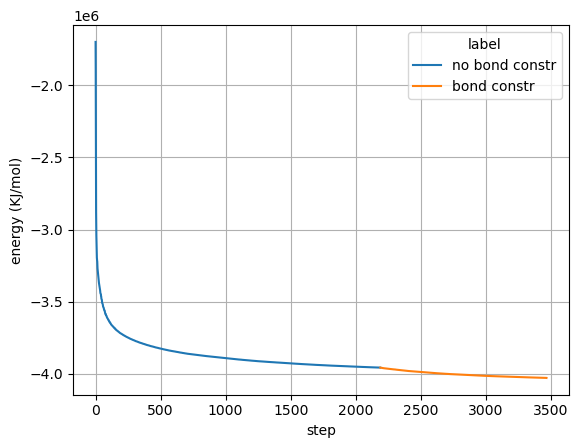

In [11]:
%%script true
ax = sns.lineplot(x="Time (ps)", y="Potential",
        hue="label",
        data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')
plt.grid()

In [12]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## From here, run in cluster
### System minimisation and equilibration

Based on `gromacs_py` docs, this is a 3-stage equilibriation process. 

All three steps seem to be NPT with berendsen coupling and v-rescale for temp coupling. Each step just has different restraints. This does not seem so bad: closer to lab conditions.

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/).

**Note:** 
1. Had to run this on cluster at least. Too slow even in ofc workstn.
2. Temperature coupling groups have to be set properly. See [mdtutorials](http://www.mdtutorials.com/gmx/complex/06_equil.html) and [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#System-equilibration)

In [ ]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_20250310.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [ ]:
#%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'
sys_name = 'dna_sequence_101_peptide_model_0'
complex_sys.equi_three_step(out_folder=equi_folder,
        name=sys_name,
        nsteps_HA=HA_step,  
        nsteps_CA=CA_step,
        nsteps_CA_LOW=CA_LOW_step,
        dt=dt, dt_HA=dt_HA,
        tc_grps='Protein_DNA Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        vsite='none', maxwarn=10, iter_num=1)

In [39]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

### Plot Equilibriation

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/). So we need to see Volume as well as Pressure, temperature, and density.

In [1]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_20250310.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [27]:
%%script true
# This code cell was for a snafu in setting the simulation name. Ignore it unless needed.
# Function to update filenames in attributes
def update_filename_in_object(obj, old_str, new_str):
    for attr, value in obj.__dict__.items():
        if isinstance(value, str) and old_str in value:
            setattr(obj, attr, value.replace(old_str, new_str))

update_filename_in_object(complex_sys, "ku04amp01_pea_complex", "dna_sequence_101_peptide_model_0")
update_filename_in_object(complex_sys.sys_history[3], "ku04amp01_pea_complex", "dna_sequence_101_peptide_model_0")
update_filename_in_object(complex_sys.sys_history[4], "ku04amp01_pea_complex", "dna_sequence_101_peptide_model_0")

In [ ]:
#%%script true
quantities = ["Temperature", "Pressure", "Volume", "Density"]
units = ["$K$", "$bar$", "$A^3$", "$kg/m^3$"]

pd_1 = complex_sys.sys_history[-2].get_ener(selection_list=quantities)
pd_2 = complex_sys.sys_history[-1].get_ener(selection_list=quantities)
pd_3 = complex_sys.get_ener(selection_list=quantities)

pd_1['label'] = 'HA_constr'
pd_2['label'] = 'CA_constr'
pd_2['Time (ps)'] = pd_2['Time (ps)'] + pd_1['Time (ps)'].max()
pd_3['label'] = 'CA_LOW_constr'
pd_3['Time (ps)'] = pd_3['Time (ps)'] + pd_2['Time (ps)'].max()

display(pd.concat([pd_1, pd_2, pd_3]))

In [ ]:
#%%script true
plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(4, 1, figsize=(24,13.5), sharex=True, tight_layout=True)

for ax, quantity, unit in zip(axs, quantities, units):
    for df in (pd_1, pd_2, pd_3):
        ax.plot(df["Time (ps)"], df[quantity], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        ax.grid()

axs[0].legend()
axs[-1].set_xlabel("Time (ps)");

Looks okay to me. Fluctuations are high at the end because CA constraints are low, but there is a well-defined average.

### Plot RMSD

In [ ]:
#%%script true
# Define reference structure for RMSD calculation
ref_sys =  complex_sys.sys_history[1]
struct="Protein"

rmsd_pd_1 = complex_sys.sys_history[-2].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_2 = complex_sys.sys_history[-1].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_3 = complex_sys.get_rmsd([struct, struct], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

display(pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3]))


In [ ]:
#%%script true
fig, ax = plt.subplots(1, 1, figsize=(24,13.5))

for df in (rmsd_pd_1, rmsd_pd_2, rmsd_pd_3):
        ax.plot(df["time"], df["Protein"], label=str(df['label'][0]))
        
ax.set_title(struct)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

### Prepare Equilibration Trajectories for Viewing 

Do this by removing artefacts (centering) and smoothening rotational and translational degrees of freedom.

In [40]:
#%%script true
# Center trajectory
complex_sys.center_mol_box(traj=True)
complex_sys.sys_history[-1].center_mol_box(traj=True)
complex_sys.sys_history[-2].center_mol_box(traj=True)

gmx make_ndx -f molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0.gro -o molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0.ndx
gmx trjconv -f molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0.xtc -o molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0_compact.xtc -s molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0.tpr -ur tric -pbc mol -center yes -n molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0.ndx
gmx make_ndx -f molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_101_peptide_model_0.gro -o molecular_dynamics/dna_sequence_1

In [42]:
#%%script true
complex_sys.convert_trj(select='Protein\nProtein_DNA', fit='rot+trans', pbc='none')
complex_sys.sys_history[-1].convert_trj(select='Protein\nProtein_DNA', fit='rot+trans', pbc='none')
complex_sys.sys_history[-2].convert_trj(select='Protein\nProtein_DNA', fit='rot+trans', pbc='none')

gmx trjconv -f molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0_compact.xtc -o molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0_compact_compact.xtc -s molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0.tpr -ur compact -pbc none -fit rot+trans -n molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_101_peptide_model_0.ndx
gmx trjconv -f molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_101_peptide_model_0_compact.xtc -o molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_101_peptide_model_0_compact_compact.xtc -s molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_101_peptide_model_0.tpr -ur compact -pbc no

### Extract Equilibration Initial Condition

In [44]:
#%%script true
equi_00_folder = "molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/00_equi_HA/"
complex_sys.sys_history[-2].convert_trj(select='Protein\nProtein_DNA', fit='rot+trans', pbc='none', specific_coor_out=equi_00_folder+"/start.pdb", dump="0")

gmx trjconv -f molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_101_peptide_model_0_compact_compact.xtc -o molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/00_equi_HA/start.pdb -s molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_101_peptide_model_0.tpr -ur compact -pbc none -dump 0 -fit rot+trans -n molecular_dynamics/dna_sequence_101_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_101_peptide_model_0.ndx


## Production MD 

tc-coupling groups are required here as well. See [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#Production)

In [ ]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_20250310.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [ ]:
%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '16'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.production(out_folder=prod_folder,
        nsteps=prod_step,
        tc_grps='Protein_DNA Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        dt=dt, vsite=vsite, maxwarn=1, nstlist=200)

## Checkpointing for extending


In [ ]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_' + datetime.date.today().strftime("%Y%m%d") + '.pycpt'
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## Post-Production

In [ ]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_20250222.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

### Prepare Production Trajectory for Viewing

#### Center Trajectory

In [ ]:
%%script true
# Center trajectory
complex_sys.center_mol_box(traj=True)

## Final Steps
As in any simulation conducted with periodic boundary conditions, molecules may appear "broken" or may "jump" back and forth across the box. To recenter the protein and rewrap the molecules within the unit cell to recover the desired box shape, invoke trjconv. 

Choose "Protein" for centering and "Protein_DNA" (prot and ligand selection) for output.

In [ ]:
%%script true
complex_sys.convert_trj(select='Protein\nProtein_DNA', fit='rot+trans', pbc='none')

#### Extract production initial condition
Optionally, extract the first frame of the final prod traj (latest from history, as the running one got updated) into a `pdb` for loading into post processing.

In [ ]:
%%script true
complex_sys.sys_history[-1].convert_trj(select='Protein\nProtein_DNA', fit='rot+trans', pbc='none', specific_coor_out=prod_folder+"/start.pdb", dump="0")